In [1]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join
import datetime
import time
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import utilities
import aggregate

# Data preparations

In [2]:
# prepare timeline
start_date = "01/01/2017 00:00:00"

dict_crypto_name, data = aggregate.aggregate("../../../history", "01.01.2017", "01.08.2017",["O","C","H","L"])
data = data.T.values
data_interpolated = utilities.interpolate_data(data)
N, T = data_interpolated.shape

Ignored currencies with not enough data for given date range: 84


In [3]:
# save data
np.savetxt('merged_transposed_series.csv', data, delimiter=';')

In [4]:
import pylab as pl

def draw_plot(true_data, index_to_check, pred_data = []):

    pl.figure(figsize=(30,5))
    if len(pred_data) > 0:
        x_axis = np.arange(len(true_data)-len(pred_data),len(true_data))
        plt.plot(x_axis, pred_data, color='red')
    pl.plot(true_data, color='blue')
    pl.title("%s"%dict_crypto_name[index_to_check])

    pl.show()

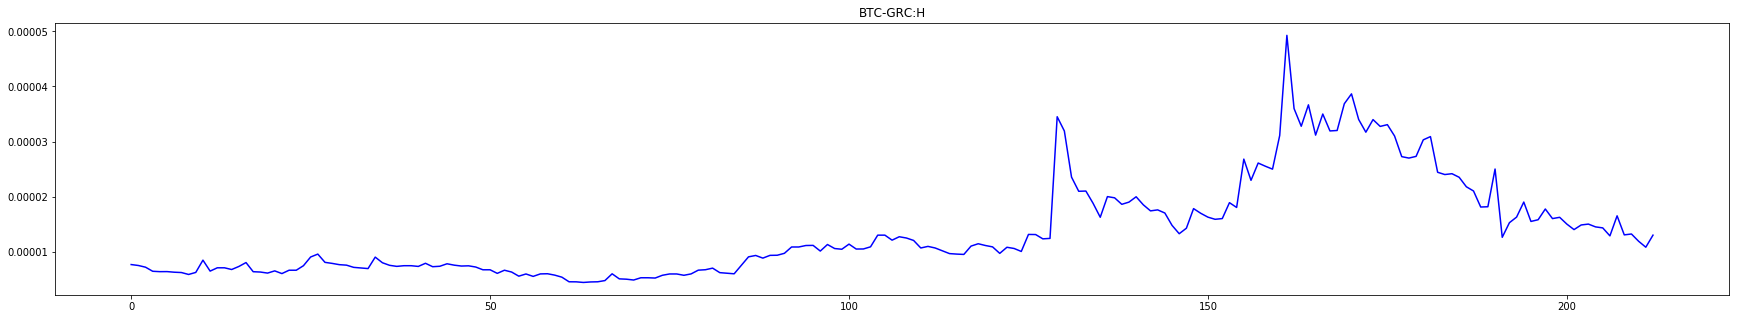

In [5]:
draw_plot(data_interpolated[34],34)

In [6]:
def draw_test_plot(model, index_to_check):

    model.fit(data_interpolated[:,:-20])
    pred_vals = model.predict(20)

    draw_plot(data_interpolated[index_to_check], index_to_check, pred_data=pred_vals[index_to_check])

# Autoregressive models for each of feature of our dataset.
The most good lags parameter was 1 for such kind of the model, but it works mostly for prediction nearest values (h = 1,5,10), but if we want farther predictions, this model doesn't fit.

In [20]:
from models import IndependentFeaturesAutoRegressionModel

In [91]:
errors_ind_ar = []
for lags in [[1],[1,7],[1,7,14],[1, 7, 14, 30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = IndependentFeaturesAutoRegressionModel(lags)
        scores_nd = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('Independent AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ind_ar.append(temp)

Independent AR performance ND/NRMSE (h = 1, lags = [1]): 0.239/0.325
Independent AR performance ND/NRMSE (h = 5, lags = [1]): 0.392/0.517
Independent AR performance ND/NRMSE (h = 10, lags = [1]): 0.396/0.63
Independent AR performance ND/NRMSE (h = 20, lags = [1]): 0.514/0.973
Independent AR performance ND/NRMSE (h = 1, lags = [1, 7]): 0.237/0.323
Independent AR performance ND/NRMSE (h = 5, lags = [1, 7]): 0.426/0.568
Independent AR performance ND/NRMSE (h = 10, lags = [1, 7]): 0.417/0.678
Independent AR performance ND/NRMSE (h = 20, lags = [1, 7]): 0.537/0.989
Independent AR performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.256/0.352
Independent AR performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 0.475/0.723
Independent AR performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.479/0.822
Independent AR performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 0.694/1.24
Independent AR performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.42/1.038
Independent AR performance ND/NRMSE (h = 5, lags 

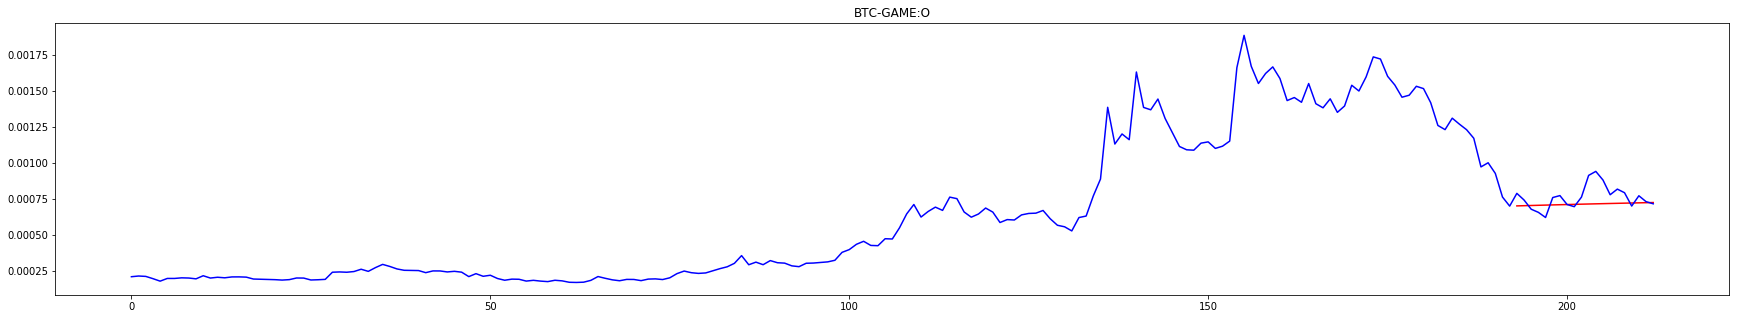

In [21]:
draw_test_plot(IndependentFeaturesAutoRegressionModel([1]), 56)

# Autoregressive model for all taken features together
The result showed that with increasing lags number we have better accuracy. 

In [24]:
from models import AutoRegressionModel
from statsmodels.tsa.vector_ar.var_model import VAR

In [99]:
errors_ar = []
for lags in [[1],[1,7],[1,7,14],[1,7,14,30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = AutoRegressionModel(lags)
        scores_nd = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


AR performance ND/NRMSE (h = 1, lags = [1]): 2.074/2.263
AR performance ND/NRMSE (h = 5, lags = [1]): 2.078/2.277
AR performance ND/NRMSE (h = 10, lags = [1]): 1.95/2.154
AR performance ND/NRMSE (h = 20, lags = [1]): 1.62/1.956
AR performance ND/NRMSE (h = 1, lags = [1, 7]): 0.312/0.399
AR performance ND/NRMSE (h = 5, lags = [1, 7]): 0.581/0.783
AR performance ND/NRMSE (h = 10, lags = [1, 7]): 0.834/1.144
AR performance ND/NRMSE (h = 20, lags = [1, 7]): 1.701/2.113
AR performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.323/0.414
AR performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 0.421/0.576
AR performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.87/1.127
AR performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 1.568/1.961
AR performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.297/0.381
AR performance ND/NRMSE (h = 5, lags = [1, 7, 14, 30]): 0.439/0.608
AR performance ND/NRMSE (h = 10, lags = [1, 7, 14, 30]): 0.664/0.892
AR performance ND/NRMSE (h = 20, lags = [1, 7, 14, 30]): 1.067/1.488

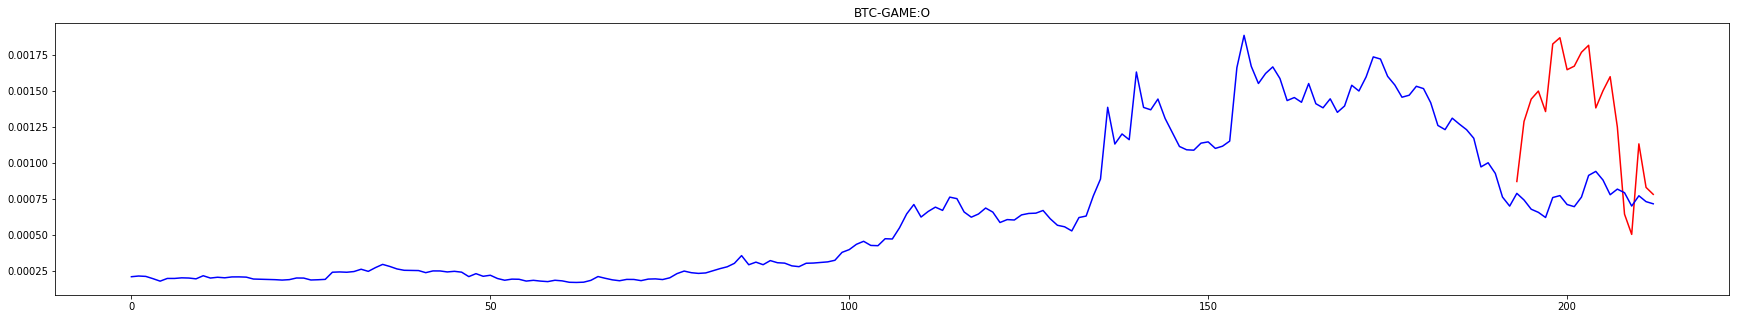

In [25]:
draw_test_plot(AutoRegressionModel([1, 7, 14, 30]), 56)

# Autoregression model with prior SVD dimension reduction for all features together
The results showed worse accuracy that just Autoregressive model, but with increasing number of lags considered accuracy is improving.

In [101]:
from models import SvdAutoRegressionModel
errors_svd_ar = []
for lags in [[1],[1,7],[1,7,14],[1,7,14,30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = SvdAutoRegressionModel(lags)
        scores_nd = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = utilities.RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('SVD AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h, lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_svd_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


SVD AR performance ND/NRMSE (h = 1, lags = [1]): 1.608/1.916
SVD AR performance ND/NRMSE (h = 5, lags = [1]): 2.587/3.434
SVD AR performance ND/NRMSE (h = 10, lags = [1]): 5.886/7.043
SVD AR performance ND/NRMSE (h = 20, lags = [1]): 3.326/4.126
SVD AR performance ND/NRMSE (h = 1, lags = [1, 7]): 0.97/1.182
SVD AR performance ND/NRMSE (h = 5, lags = [1, 7]): 1.014/1.251
SVD AR performance ND/NRMSE (h = 10, lags = [1, 7]): 0.928/1.217
SVD AR performance ND/NRMSE (h = 20, lags = [1, 7]): 0.99/1.385
SVD AR performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.982/1.218
SVD AR performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 1.019/1.274
SVD AR performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.995/1.27
SVD AR performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 1.038/1.432
SVD AR performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 1.051/1.302
SVD AR performance ND/NRMSE (h = 5, lags = [1, 7, 14, 30]): 1.042/1.31
SVD AR performance ND/NRMSE (h = 10, lags = [1, 7, 14, 30]): 1.059/1.331
SVD AR pe

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


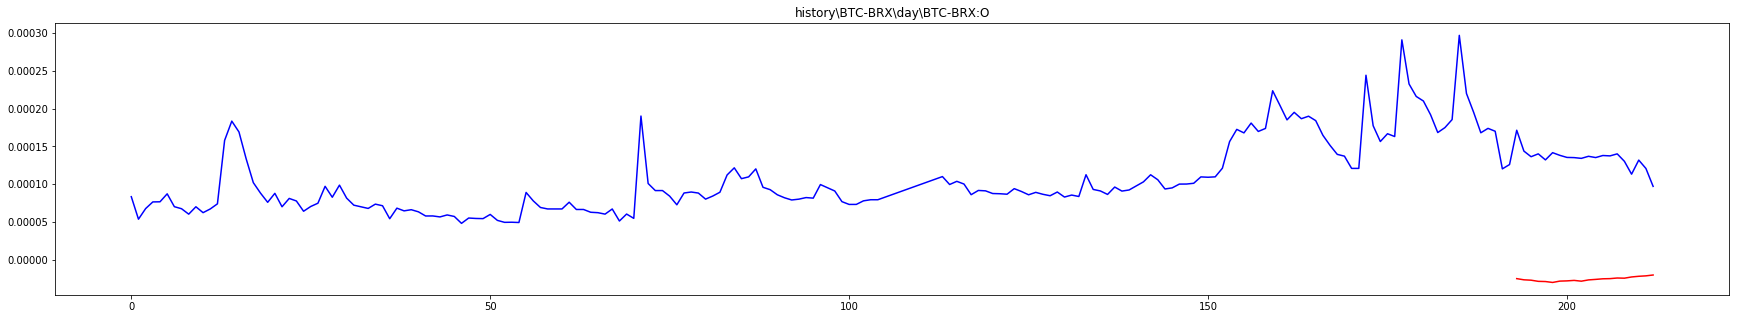

In [109]:
draw_test_plot(SvdAutoRegressionModel([1,7,14]), 56)

# Simple TRMF model

The results so far worse than Autoregressive model because of algorithm's simpleness and small number of iterations.

In [26]:
from trmf_naive import TRMFNaive

lags = [1,2,3,4,5,6,7,14,21]
rank = 256
lambda_f = 0.001
lambda_x = 0.01
lambda_w = 0.0001
alpha = 1000.
eta = 0.
num_iter = 200

In [104]:
for h in [1, 5, 10, 20]:
    model = TRMFNaive(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, num_iter)
    scores_nd = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='ND')
    scores_nrmse = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='NRMSE')
    print('TRMFNaive performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(), 3), \
                                                             round(np.array(scores_nrmse).mean(), 3)))

TRMFNaive performance ND/NRMSE (h = 1): 1.489/1.991
TRMFNaive performance ND/NRMSE (h = 5): 1.369/1.631
TRMFNaive performance ND/NRMSE (h = 10): 1.048/1.355
TRMFNaive performance ND/NRMSE (h = 20): 1.003/1.345


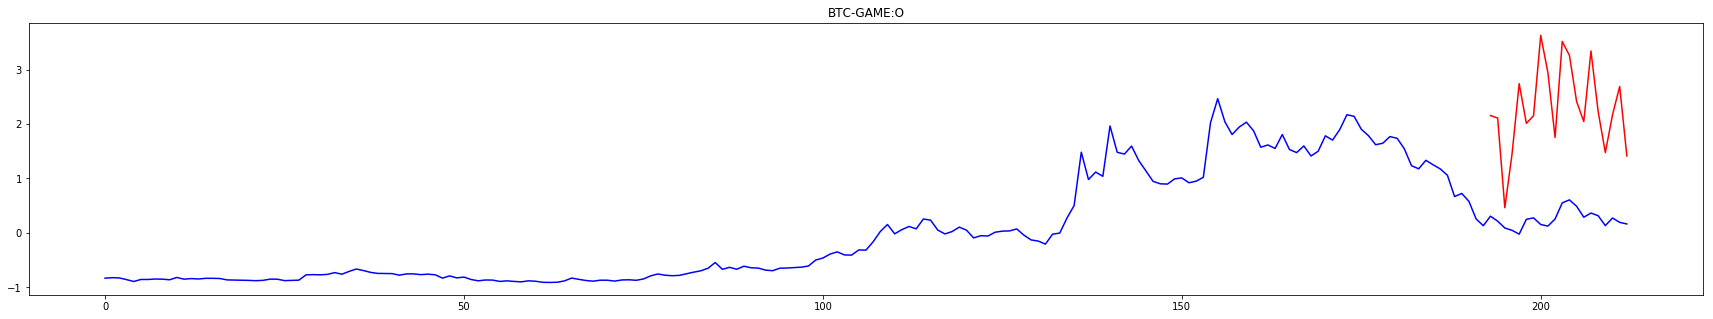

In [27]:
horizon = 20
check_idx = 56
model = TRMFNaive(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, 2000)
train, test = get_slice(data, T - horizon, horizon, 0)
model.fit(train)
predicted_data = model.predict(horizon)
draw_plot(np.concatenate((train[check_idx],test[check_idx]),axis=0), check_idx, predicted_data[check_idx])

# TRMF model

In [6]:
from models import TRMF

In [8]:
T = data.shape[1]
errors_ind_ar = []
for lags in [[1],[1,7],[1,7,14],[1,7,14,30],[1,2,3,4,5,6,7,14,21]]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = TRMF(lags=lags)
        scores_nd = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='ND', normalize=False)
        scores_nrmse = utilities.RollingCV(model, data, T - h, h, T_step=1, metric='NRMSE', normalize=False)
        print('TRMF performance ND/NRMSE (h = {}, lags = {}): {}/{}'
              .format(h, lags, round(np.array(scores_nd).mean(), 3), round(np.array(scores_nrmse).mean(), 3)))
        temp.append((round(np.array(scores_nd).mean(), 3), round(np.array(scores_nrmse).mean(), 3)))
    errors_ind_ar.append(temp)

TRMF performance ND/NRMSE (h = 1, lags = [1]): 0.073/0.938
TRMF performance ND/NRMSE (h = 5, lags = [1]): 0.106/1.251
TRMF performance ND/NRMSE (h = 10, lags = [1]): 0.068/0.878
TRMF performance ND/NRMSE (h = 20, lags = [1]): 0.124/1.611
TRMF performance ND/NRMSE (h = 1, lags = [1, 7]): 0.073/0.938
TRMF performance ND/NRMSE (h = 5, lags = [1, 7]): 0.106/1.251
TRMF performance ND/NRMSE (h = 10, lags = [1, 7]): 0.068/0.878
TRMF performance ND/NRMSE (h = 20, lags = [1, 7]): 0.124/1.611
TRMF performance ND/NRMSE (h = 1, lags = [1, 7, 14]): 0.073/0.938
TRMF performance ND/NRMSE (h = 5, lags = [1, 7, 14]): 0.106/1.251
TRMF performance ND/NRMSE (h = 10, lags = [1, 7, 14]): 0.068/0.878
TRMF performance ND/NRMSE (h = 20, lags = [1, 7, 14]): 0.124/1.611
TRMF performance ND/NRMSE (h = 1, lags = [1, 7, 14, 30]): 0.066/0.897
TRMF performance ND/NRMSE (h = 5, lags = [1, 7, 14, 30]): 0.095/1.125
TRMF performance ND/NRMSE (h = 10, lags = [1, 7, 14, 30]): 0.055/0.719
TRMF performance ND/NRMSE (h = 20, 

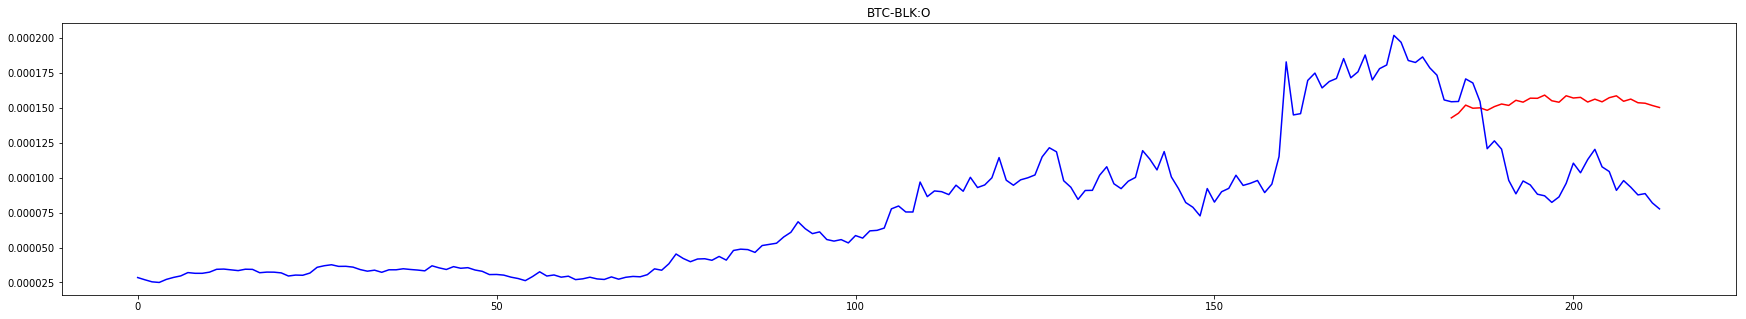

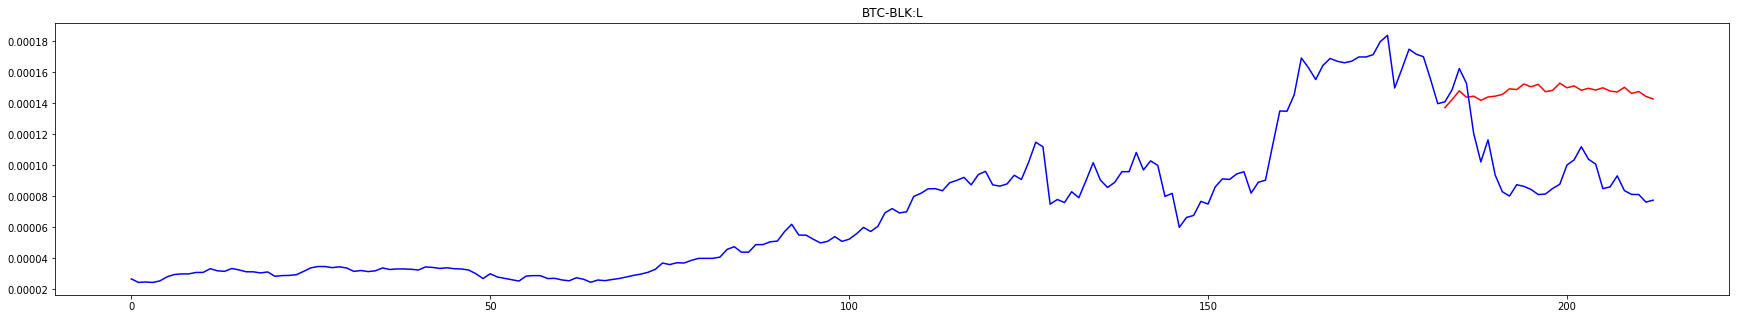

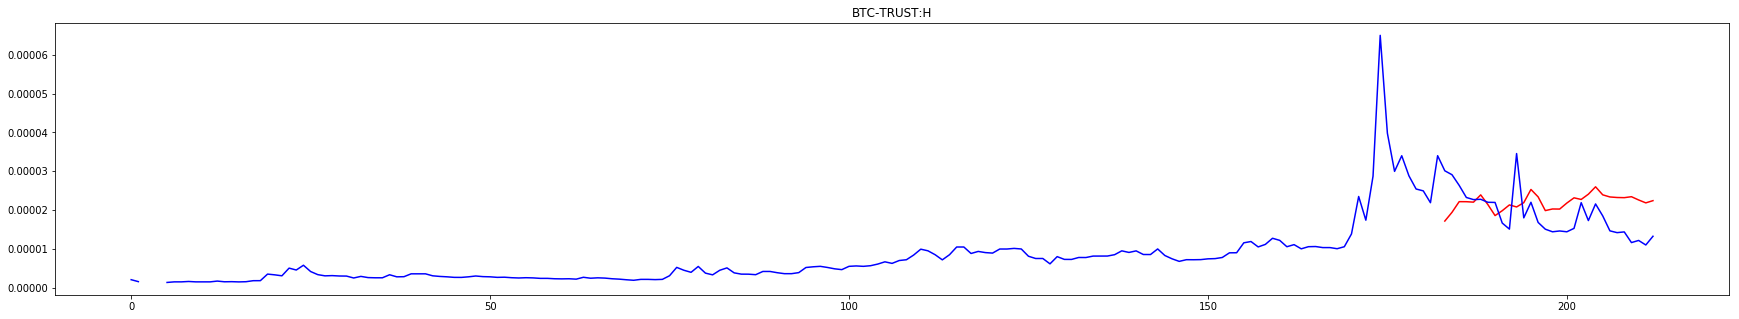

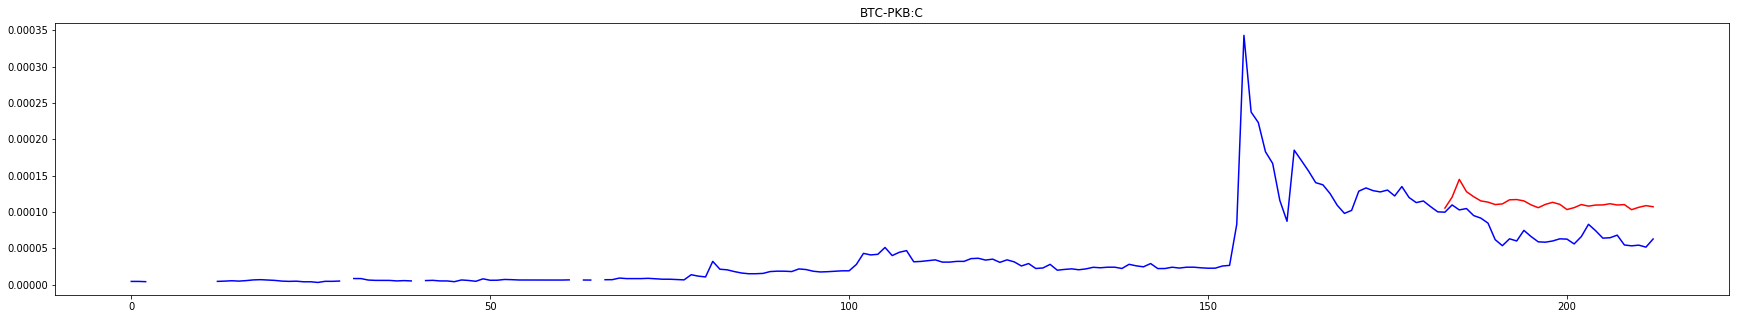

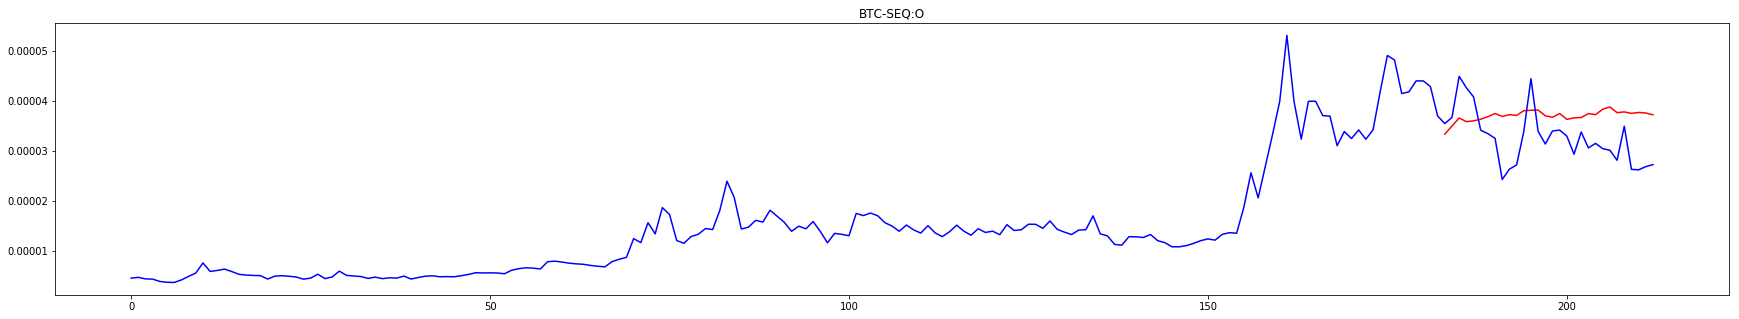

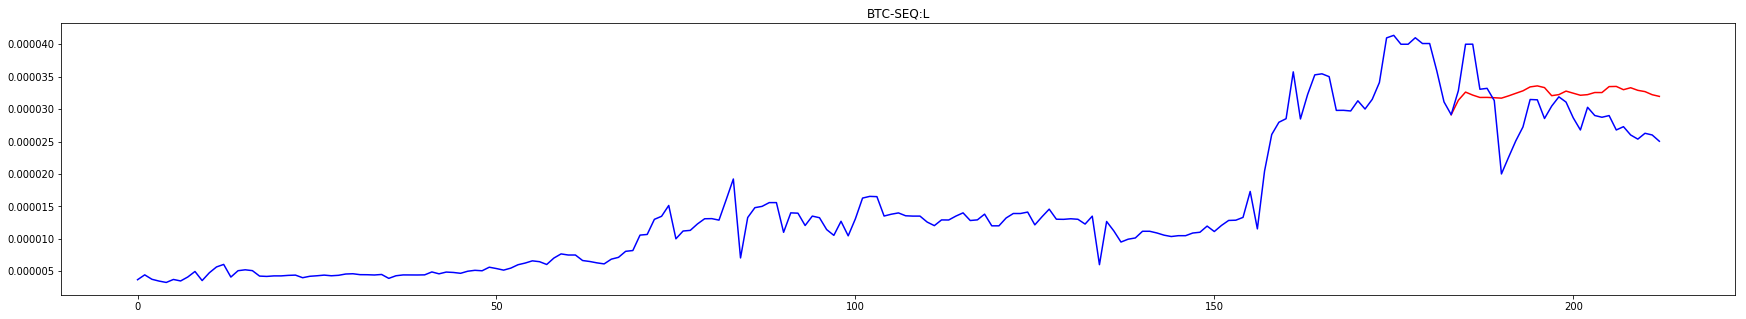

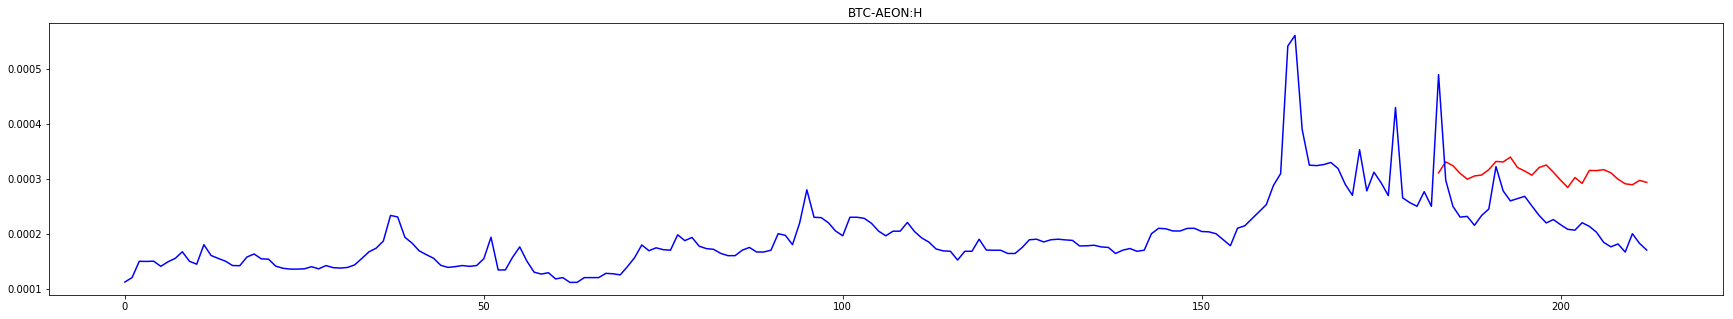

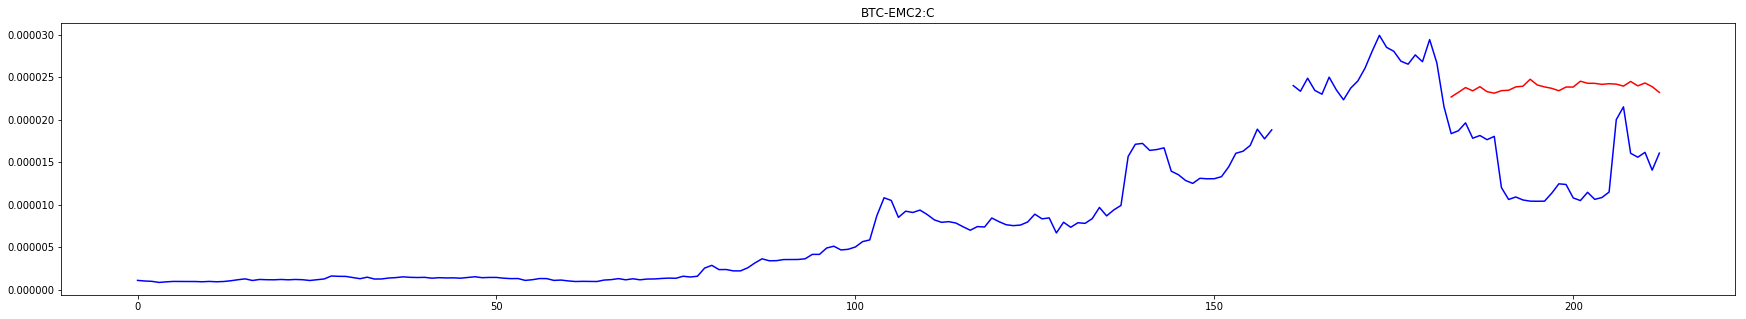

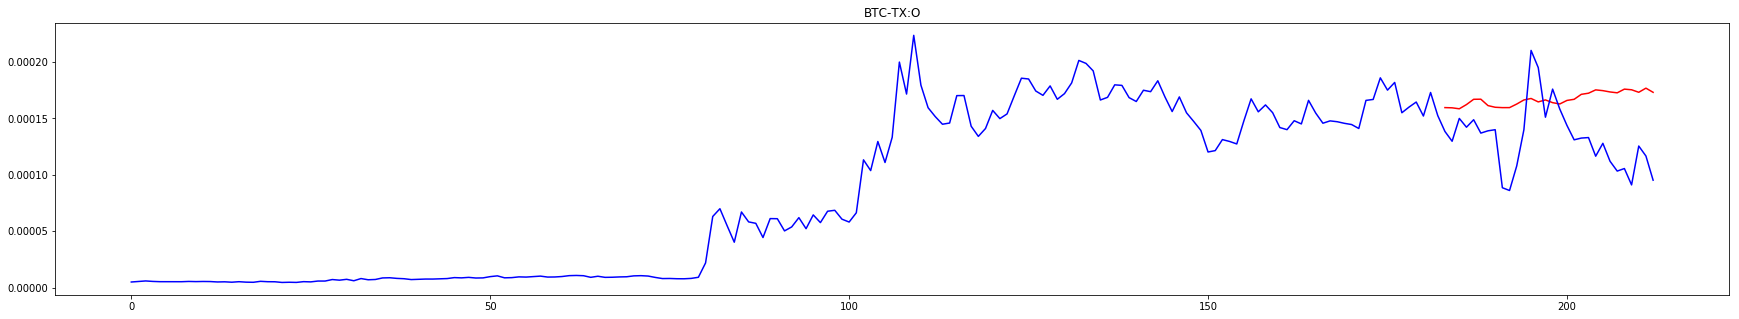

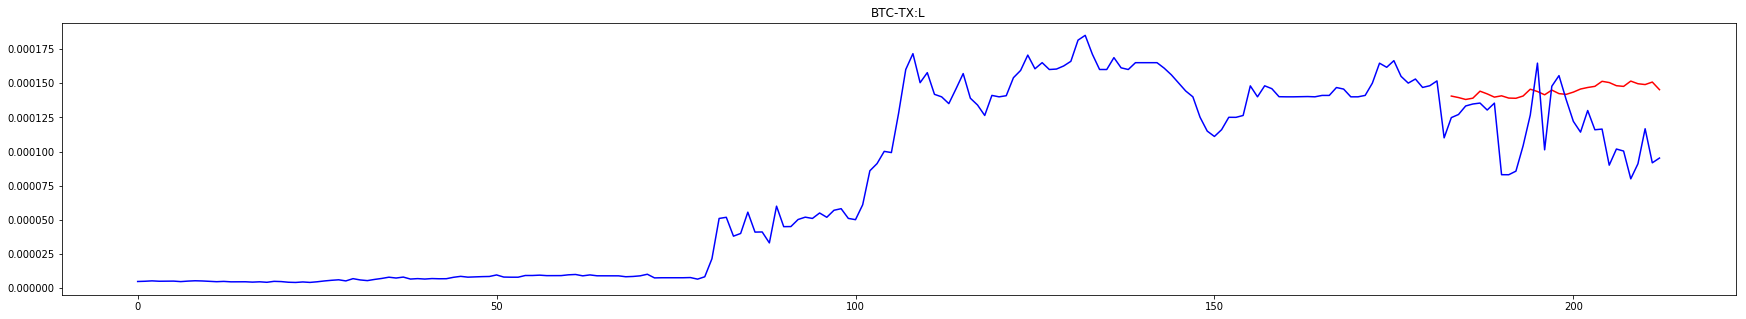

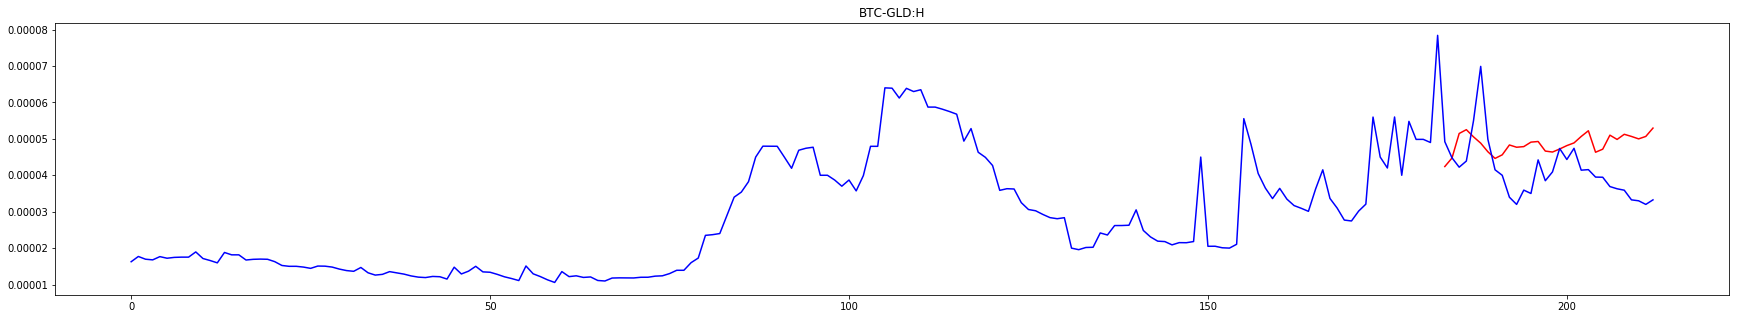

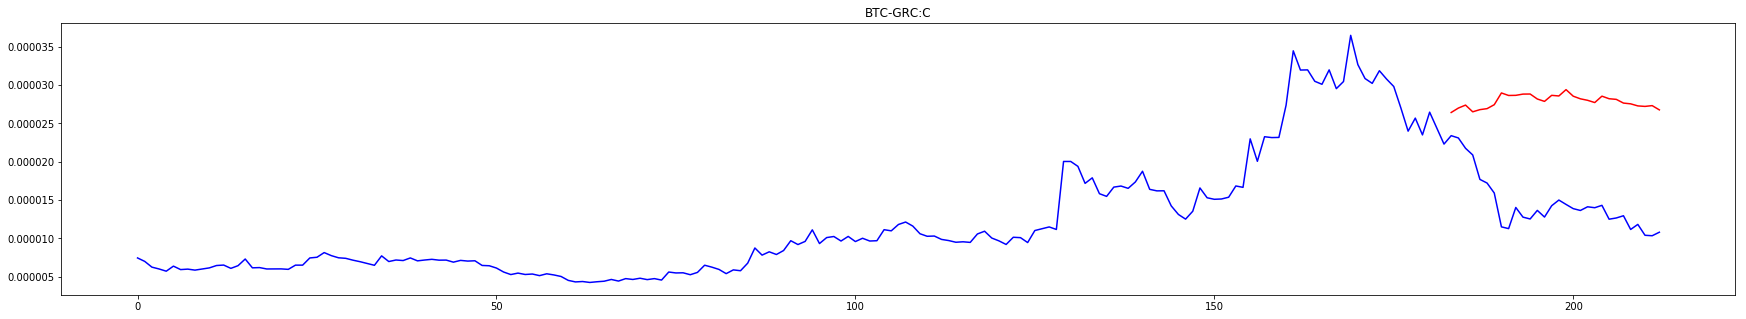

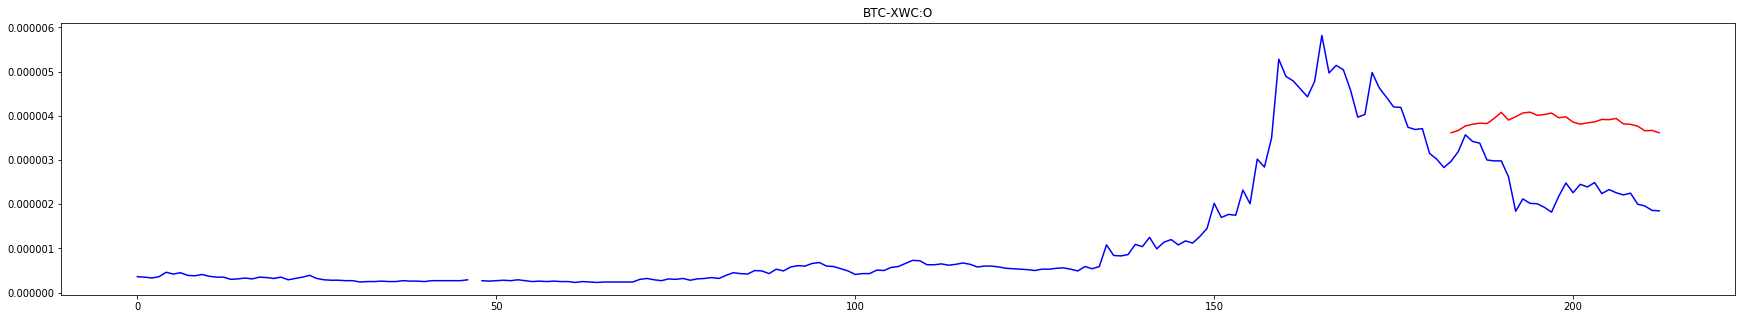

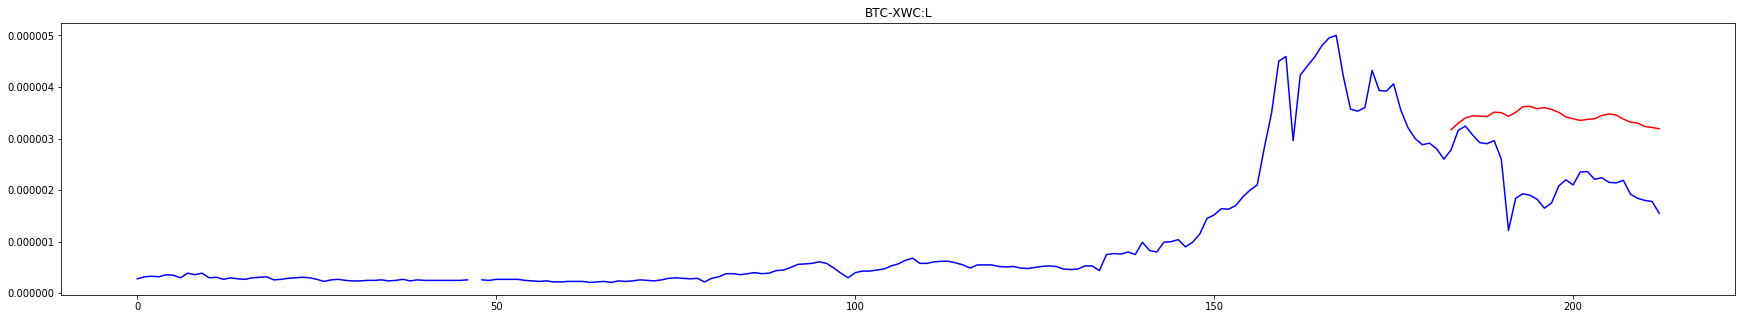

In [10]:
trmf_model = TRMF(lags = [1, 7, 14, 30])
pred_vals = utilities.fit_predict_trmf(trmf_model, data[:, :-30], 30)
for index_to_check in range(0, 40, 3):
    draw_plot(data[index_to_check], index_to_check, pred_data=pred_vals[index_to_check])